# Why use activation functions? — NNFS Chapter 3

In this section we look at **why** we need nonlinear activation functions in the hidden layers.

The key idea:

- Many interesting real‑world problems are **nonlinear** (they can't be represented well by a straight line).
- If all the layers in a neural network use a **linear** activation (\(y = x\)), then the whole network collapses to just **one big linear function**.
- To approximate nonlinear functions like \(y = \sin(x)\), we need **nonlinear activations** (like ReLU) in the hidden layers.

We'll:

1. Plot the target function \(y = \sin(x)\).
2. Fit a **purely linear model** to this data and see its limitation.
3. Fit a small neural network with **ReLU hidden layers** to show how nonlinearity lets us approximate \(\sin(x)\) much better.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Make plots a bit nicer
def setup_axes(title=None):
    plt.axhline(0, color="tab:blue", alpha=0.3, linewidth=1)
    plt.axvline(0, color="tab:blue", alpha=0.3, linewidth=1)
    if title is not None:
        plt.title(title)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid(True)

# Our target function
def f(x):
    return np.sin(x)

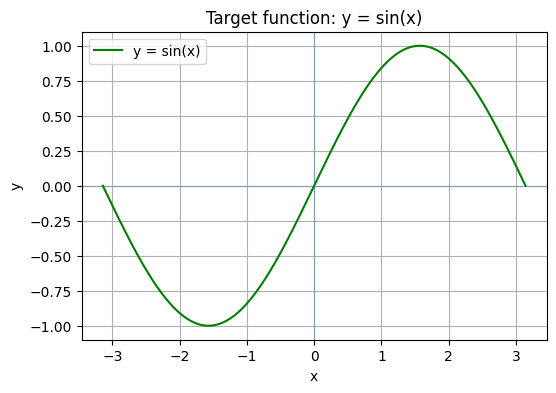

In [2]:
# 1. Plot y = sin(x)

x = np.linspace(-np.pi, np.pi, 400)
y = f(x)

plt.figure(figsize=(6, 4))
plt.plot(x, y, color="green", label="y = sin(x)")
setup_axes("Target function: y = sin(x)")
plt.legend()
plt.show()

Best linear fit: y = 0.300 * x + 0.000


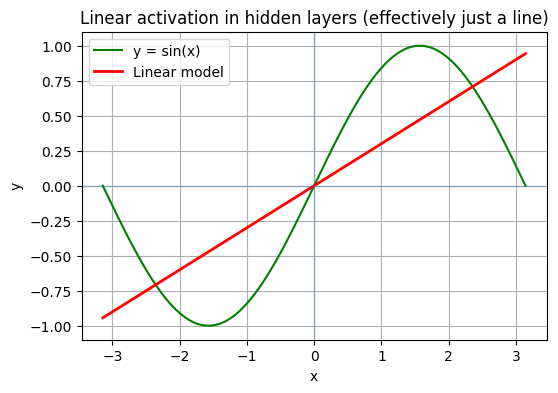

In [3]:
# 2. Fit a purely linear model y = a*x + b to sin(x)

# Sample training points
x_train = np.linspace(-np.pi, np.pi, 256)
y_train = f(x_train)

# Fit a straight line with least squares
a, b = np.polyfit(x_train, y_train, deg=1)
print(f"Best linear fit: y = {a:.3f} * x + {b:.3f}")

y_linear = a * x + b  # evaluate on the dense grid used for plotting

plt.figure(figsize=(6, 4))
plt.plot(x, y, color="green", label="y = sin(x)")
plt.plot(x, y_linear, color="red", label="Linear model", linewidth=2)
setup_axes("Linear activation in hidden layers (effectively just a line)")
plt.legend()
plt.show()

In [4]:
# 3. A small ReLU network to approximate sin(x)

rng = np.random.default_rng(42)

def relu(x):
    return np.maximum(0, x)

# Architecture: 1 -> 8 -> 8 -> 1  (like (1, 8, 8, 1) in the book)
n_hidden = 8

W1 = rng.normal(scale=0.5, size=(1, n_hidden))
b1 = np.zeros(n_hidden)

W2 = rng.normal(scale=0.5, size=(n_hidden, n_hidden))
b2 = np.zeros(n_hidden)

W3 = rng.normal(scale=0.5, size=(n_hidden, 1))
b3 = np.zeros(1)

def forward(x):
    """Forward pass for the (1, 8, 8, 1) ReLU network.
    
    x: array of shape (n_samples, 1)
    returns: predictions of shape (n_samples, 1)
    """
    z1 = x @ W1 + b1          # (n, 8)
    a1 = relu(z1)             # (n, 8)
    z2 = a1 @ W2 + b2         # (n, 8)
    a2 = relu(z2)             # (n, 8)
    y_pred = a2 @ W3 + b3     # (n, 1)
    return y_pred, (z1, a1, z2, a2)

In [5]:
# Training loop (simple gradient descent on MSE)

x_train = np.linspace(-np.pi, np.pi, 256).reshape(-1, 1)
y_train = f(x_train)

learning_rate = 0.01
epochs = 5000

for epoch in range(epochs):
    # Forward pass
    y_pred, (z1, a1, z2, a2) = forward(x_train)
    
    # Mean squared error loss
    error = y_pred - y_train
    loss = np.mean(error**2)
    
    # Gradient of loss w.r.t y_pred
    dL_dy = 2 * error / len(x_train)  # (n, 1)
    
    # Backprop into W3, b3, and a2
    dL_dW3 = a2.T @ dL_dy             # (8, 1)
    dL_db3 = np.sum(dL_dy, axis=0)    # (1,)
    dL_da2 = dL_dy @ W3.T             # (n, 8)
    
    # Through ReLU at layer 2
    relu_grad_z2 = (z2 > 0).astype(float)
    dL_dz2 = dL_da2 * relu_grad_z2    # (n, 8)
    
    dL_dW2 = a1.T @ dL_dz2            # (8, 8)
    dL_db2 = np.sum(dL_dz2, axis=0)   # (8,)
    dL_da1 = dL_dz2 @ W2.T            # (n, 8)
    
    # Through ReLU at layer 1
    relu_grad_z1 = (z1 > 0).astype(float)
    dL_dz1 = dL_da1 * relu_grad_z1    # (n, 8)
    
    dL_dW1 = x_train.T @ dL_dz1       # (1, 8)
    dL_db1 = np.sum(dL_dz1, axis=0)   # (8,)
    
    # Gradient descent step
    W3 -= learning_rate * dL_dW3
    b3 -= learning_rate * dL_db3
    W2 -= learning_rate * dL_dW2
    b2 -= learning_rate * dL_db2
    W1 -= learning_rate * dL_dW1
    b1 -= learning_rate * dL_db1
    
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch {epoch + 1}/{epochs}, loss = {loss:.5f}")

Epoch 1000/5000, loss = 0.08681
Epoch 2000/5000, loss = 0.01454
Epoch 3000/5000, loss = 0.00492
Epoch 4000/5000, loss = 0.00304
Epoch 5000/5000, loss = 0.00213


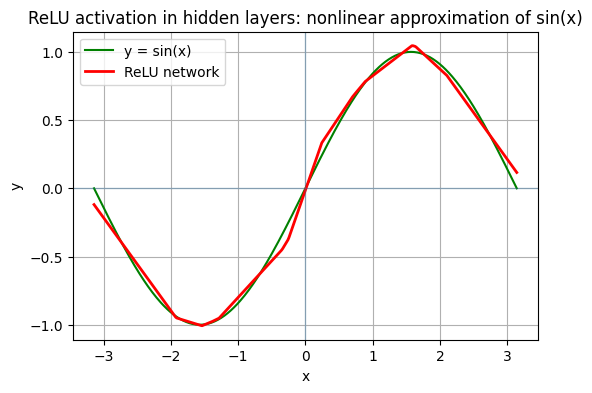

In [6]:
# Plot the ReLU network's approximation against sin(x)

x_plot = np.linspace(-np.pi, np.pi, 400).reshape(-1, 1)
y_plot = f(x_plot)
y_relu, _ = forward(x_plot)

plt.figure(figsize=(6, 4))
plt.plot(x_plot, y_plot, color="green", label="y = sin(x)")
plt.plot(x_plot, y_relu, color="red", label="ReLU network", linewidth=2)
setup_axes("ReLU activation in hidden layers: nonlinear approximation of sin(x)")
plt.legend()
plt.show()